### Defect Classifications of AOI
Resource :
https://aidea-web.tw/topic/a49e3f76-69c9-4a4a-bcfc-c882840b3f27

This is an example how to solve classification problem from defect classification dataset. We can train with our own network design. For this competition the baseline accuracy is 0.998521. We can use this dataset for try another approach.

#### Import Libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import os
from shutil import copyfile, move
from tqdm import tqdm
import h5py

In [24]:
print(tf.__version__)
print(tf.test.is_gpu_available())

1.11.0
False


#### Read the csv file

In [25]:
training_df = pd.read_csv("train.csv")
training_df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


#### Create Directory for Training and Validation Data
#### Directory dataset should be:
...train/
class 0
class 1
class 2
class 3
class 4
class 5

...validation/
class 0
class 1
class 2
class 3
class 4
class 5

...test/
test image


In [26]:
src = "train_images/"
dst = "training_data/"

In [27]:

os.mkdir(dst)
os.mkdir(dst+"0")
os.mkdir(dst+"1")
os.mkdir(dst+"2")
os.mkdir(dst+"3")
os.mkdir(dst+"4")
os.mkdir(dst+"5")

with tqdm(total=len(list(training_df.iterrows()))) as pbar:
    for idx, row in training_df.iterrows():
        pbar.update(0)
        if row["Label"] == 0:
            copyfile(src+row["ID"], dst+"0/"+row["ID"])
        elif row["Label"] == 1:
            copyfile(src+row["ID"], dst+"1/"+row["ID"])
        elif row["Label"] == 2:
            copyfile(src+row["ID"], dst+"2/"+row["ID"])
        elif row["Label"] == 3:
            copyfile(src+row["ID"], dst+"3/"+row["ID"])
        elif row["Label"] == 4:
            copyfile(src+row["ID"], dst+"4/"+row["ID"])
        elif row["Label"] == 5:
            copyfile(src+row["ID"], dst+"5/"+row["ID"])
            
            

  0%|                                                                                         | 0/2528 [00:02<?, ?it/s]


In [28]:
src = "training_data/"
dst = "validation_data/"

In [29]:


os.mkdir(dst)
os.mkdir(dst+"0")
os.mkdir(dst+"1")
os.mkdir(dst+"2")
os.mkdir(dst+"3")
os.mkdir(dst+"4")
os.mkdir(dst+"5")

validation_df = training_df.sample(n=int(len(training_df)/10))

with tqdm(total=len(list(validation_df.iterrows()))) as pbar:
    for idx, row in validation_df.iterrows():
        pbar.update(0)
        if row["Label"] == 0:
            move(src+"0/"+row["ID"], dst+"0/"+row["ID"])
        elif row["Label"] == 1:
            move(src+"1/"+row["ID"], dst+"1/"+row["ID"])
        elif row["Label"] == 2:
            move(src+"2/"+row["ID"], dst+"2/"+row["ID"])
        elif row["Label"] == 3:
            move(src+"3/"+row["ID"], dst+"3/"+row["ID"])
        elif row["Label"] == 4:
            move(src+"4/"+row["ID"], dst+"4/"+row["ID"])
        elif row["Label"] == 5:
            move(src+"5/"+row["ID"], dst+"5/"+row["ID"])

  0%|                                                                                          | 0/252 [00:00<?, ?it/s]


#### Data Augmentation

In [30]:
batch_size = 32

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True)

train_data_dir = "training_data"
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='binary')


validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_data_dir = "validation_data"
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='binary')

input_shape = (32,32,3)
num_classes = 6

Using TensorFlow backend.


Found 2276 images belonging to 6 classes.
Found 252 images belonging to 6 classes.


#### Show sampling images

In [31]:
sample_training_images, _ = next(train_generator)

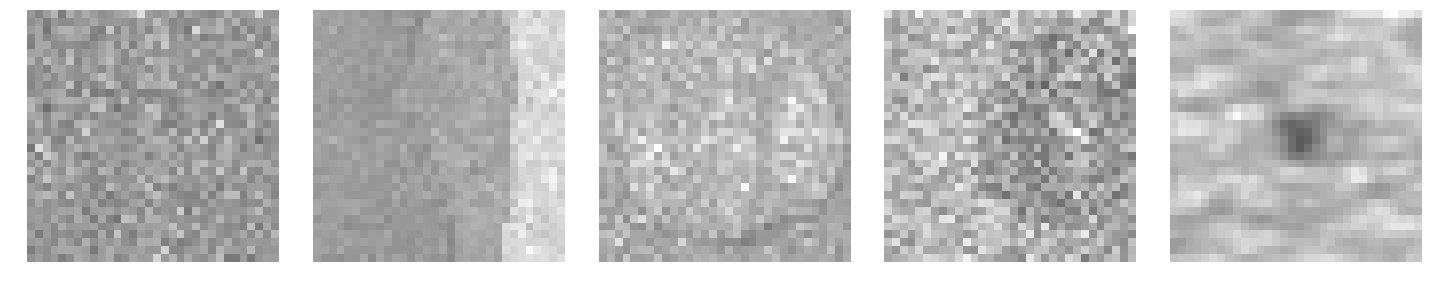

In [32]:
def plotImages(images_arr): 
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])

#### Import libraries for a model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Model Creation: Convolutional Neural Network

In [34]:
dropout_dense_layer = 0.7
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(6))
model.add(Activation('softmax'))

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
__________

#### Setting up Model Parameters

In [36]:
model.compile(loss=tf.keras.losses.
              sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.001),
              metrics=['accuracy'])

In [37]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

#### Training and Validating

In [38]:
epochs = 30
history = model.fit_generator(train_generator,
          validation_data=validation_generator,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          callbacks = callbacks)

Epoch 1/100
72/72 [==============================] - 18s 243ms/step - loss: 2.0115 - acc: 0.2183 - val_loss: 1.7606 - val_acc: 0.2976
Epoch 2/100
72/72 [==============================] - 14s 201ms/step - loss: 1.8440 - acc: 0.2561 - val_loss: 1.7274 - val_acc: 0.2976
Epoch 3/100
72/72 [==============================] - 15s 204ms/step - loss: 1.7331 - acc: 0.2856 - val_loss: 1.7034 - val_acc: 0.2976
Epoch 4/100
72/72 [==============================] - 15s 210ms/step - loss: 1.6184 - acc: 0.3580 - val_loss: 1.6729 - val_acc: 0.2976
Epoch 5/100
72/72 [==============================] - 15s 213ms/step - loss: 1.5347 - acc: 0.4089 - val_loss: 1.6353 - val_acc: 0.3294
Epoch 6/100
72/72 [==============================] - 15s 207ms/step - loss: 1.4300 - acc: 0.4566 - val_loss: 1.5510 - val_acc: 0.4206
Epoch 7/100
72/72 [==============================] - 15s 208ms/step - loss: 1.3793 - acc: 0.4747 - val_loss: 1.3408 - val_acc: 0.5992
Epoch 8/100
72/72 [==============================] - 15s 212ms

Epoch 62/100
72/72 [==============================] - 15s 209ms/step - loss: 0.6901 - acc: 0.7778 - val_loss: 0.5745 - val_acc: 0.8095
Epoch 63/100
72/72 [==============================] - 15s 211ms/step - loss: 0.6828 - acc: 0.7714 - val_loss: 0.4884 - val_acc: 0.8492
Epoch 64/100
72/72 [==============================] - 15s 215ms/step - loss: 0.6760 - acc: 0.7696 - val_loss: 0.6311 - val_acc: 0.7698
Epoch 65/100
72/72 [==============================] - 15s 215ms/step - loss: 0.6617 - acc: 0.7792 - val_loss: 0.7070 - val_acc: 0.7579
Epoch 66/100
72/72 [==============================] - 16s 217ms/step - loss: 0.6377 - acc: 0.7808 - val_loss: 0.6272 - val_acc: 0.7778
Epoch 67/100
72/72 [==============================] - 16s 223ms/step - loss: 0.6586 - acc: 0.7697 - val_loss: 0.5836 - val_acc: 0.7937
Epoch 68/100
72/72 [==============================] - 15s 206ms/step - loss: 0.6494 - acc: 0.7930 - val_loss: 0.5347 - val_acc: 0.8175
Epoch 69/100
72/72 [==============================] - 1

#### Plot on Graphic

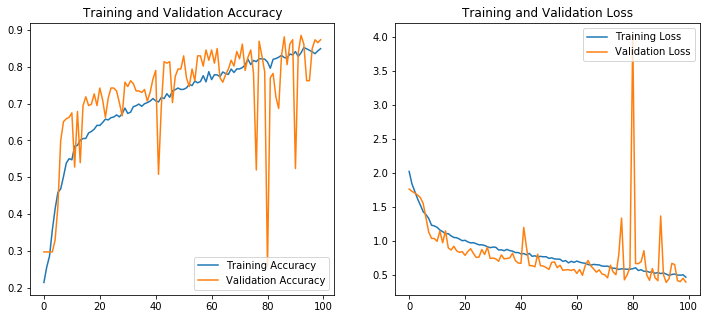

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

x=0
y=0
for i in val_acc[-(len(epochs)//5):]:
    x+=1
    y+=i
print(y/x)

#### Save weight

In [40]:
model.load_weights("best_model.h5")

#### Testing on test_data

In [41]:
import shutil
import os
os.makedirs("testing")
shutil.move("test_images","testing/test_images")
test_set = "testing"
test_datagen = ImageDataGenerator(
    rescale=1./ 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_set,
    target_size=(32,32),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

filenames = test_generator.filenames
nb_samples = len(filenames)





Found 10142 images belonging to 1 classes.


In [42]:
predict = model.predict_generator(test_generator,steps = nb_samples, verbose=1)


10142/10142 [==============================] - 42s 4ms/step


In [43]:
#Generate the submission .csv file.

In [44]:
#sample probability result of one images 
print(predict[0])
label = np.where(predict[0]==max(predict[0]))

[0.0039944  0.82019377 0.00360749 0.1570984  0.01372181 0.00138408]


In [45]:
label_map = train_generator.class_indices
print(label_map)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}


In [48]:
#create new file submission for see the result

csv_file = open("sample_submission_cnn.csv","w")
csv_file.write("id,label\n")
for filename, prediction in zip(filenames,predict):
    name = filename.split("\\")
    print(name)
    name = name[1]
    label = np.where(prediction==max(prediction))
    label = label[0][0]
    csv_file.write(str(name)+","+str(label)+"\n")
csv_file.close()

['test_images', 'test_00000.png']
['test_images', 'test_00001.png']
['test_images', 'test_00002.png']
['test_images', 'test_00003.png']
['test_images', 'test_00004.png']
['test_images', 'test_00005.png']
['test_images', 'test_00006.png']
['test_images', 'test_00007.png']
['test_images', 'test_00008.png']
['test_images', 'test_00009.png']
['test_images', 'test_00010.png']
['test_images', 'test_00011.png']
['test_images', 'test_00012.png']
['test_images', 'test_00013.png']
['test_images', 'test_00014.png']
['test_images', 'test_00015.png']
['test_images', 'test_00016.png']
['test_images', 'test_00017.png']
['test_images', 'test_00018.png']
['test_images', 'test_00019.png']
['test_images', 'test_00020.png']
['test_images', 'test_00021.png']
['test_images', 'test_00022.png']
['test_images', 'test_00023.png']
['test_images', 'test_00024.png']
['test_images', 'test_00025.png']
['test_images', 'test_00026.png']
['test_images', 'test_00027.png']
['test_images', 'test_00028.png']
['test_images'

['test_images', 'test_02688.png']
['test_images', 'test_02689.png']
['test_images', 'test_02690.png']
['test_images', 'test_02691.png']
['test_images', 'test_02692.png']
['test_images', 'test_02693.png']
['test_images', 'test_02694.png']
['test_images', 'test_02695.png']
['test_images', 'test_02696.png']
['test_images', 'test_02697.png']
['test_images', 'test_02698.png']
['test_images', 'test_02699.png']
['test_images', 'test_02700.png']
['test_images', 'test_02701.png']
['test_images', 'test_02702.png']
['test_images', 'test_02703.png']
['test_images', 'test_02704.png']
['test_images', 'test_02705.png']
['test_images', 'test_02706.png']
['test_images', 'test_02707.png']
['test_images', 'test_02708.png']
['test_images', 'test_02709.png']
['test_images', 'test_02710.png']
['test_images', 'test_02711.png']
['test_images', 'test_02712.png']
['test_images', 'test_02713.png']
['test_images', 'test_02714.png']
['test_images', 'test_02715.png']
['test_images', 'test_02716.png']
['test_images'

['test_images', 'test_05078.png']
['test_images', 'test_05079.png']
['test_images', 'test_05080.png']
['test_images', 'test_05081.png']
['test_images', 'test_05082.png']
['test_images', 'test_05083.png']
['test_images', 'test_05084.png']
['test_images', 'test_05085.png']
['test_images', 'test_05086.png']
['test_images', 'test_05087.png']
['test_images', 'test_05088.png']
['test_images', 'test_05089.png']
['test_images', 'test_05090.png']
['test_images', 'test_05091.png']
['test_images', 'test_05092.png']
['test_images', 'test_05093.png']
['test_images', 'test_05094.png']
['test_images', 'test_05095.png']
['test_images', 'test_05096.png']
['test_images', 'test_05097.png']
['test_images', 'test_05098.png']
['test_images', 'test_05099.png']
['test_images', 'test_05100.png']
['test_images', 'test_05101.png']
['test_images', 'test_05102.png']
['test_images', 'test_05103.png']
['test_images', 'test_05104.png']
['test_images', 'test_05105.png']
['test_images', 'test_05106.png']
['test_images'

['test_images', 'test_07578.png']
['test_images', 'test_07579.png']
['test_images', 'test_07580.png']
['test_images', 'test_07581.png']
['test_images', 'test_07582.png']
['test_images', 'test_07583.png']
['test_images', 'test_07584.png']
['test_images', 'test_07585.png']
['test_images', 'test_07586.png']
['test_images', 'test_07587.png']
['test_images', 'test_07588.png']
['test_images', 'test_07589.png']
['test_images', 'test_07590.png']
['test_images', 'test_07591.png']
['test_images', 'test_07592.png']
['test_images', 'test_07593.png']
['test_images', 'test_07594.png']
['test_images', 'test_07595.png']
['test_images', 'test_07596.png']
['test_images', 'test_07597.png']
['test_images', 'test_07598.png']
['test_images', 'test_07599.png']
['test_images', 'test_07600.png']
['test_images', 'test_07601.png']
['test_images', 'test_07602.png']
['test_images', 'test_07603.png']
['test_images', 'test_07604.png']
['test_images', 'test_07605.png']
['test_images', 'test_07606.png']
['test_images'

['test_images', 'test_10077.png']
['test_images', 'test_10078.png']
['test_images', 'test_10079.png']
['test_images', 'test_10080.png']
['test_images', 'test_10081.png']
['test_images', 'test_10082.png']
['test_images', 'test_10083.png']
['test_images', 'test_10084.png']
['test_images', 'test_10085.png']
['test_images', 'test_10086.png']
['test_images', 'test_10087.png']
['test_images', 'test_10088.png']
['test_images', 'test_10089.png']
['test_images', 'test_10090.png']
['test_images', 'test_10091.png']
['test_images', 'test_10092.png']
['test_images', 'test_10093.png']
['test_images', 'test_10094.png']
['test_images', 'test_10095.png']
['test_images', 'test_10096.png']
['test_images', 'test_10097.png']
['test_images', 'test_10098.png']
['test_images', 'test_10099.png']
['test_images', 'test_10100.png']
['test_images', 'test_10101.png']
['test_images', 'test_10102.png']
['test_images', 'test_10103.png']
['test_images', 'test_10104.png']
['test_images', 'test_10105.png']
['test_images'